# System analysis

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

### 1) Load data from BIN files

In [49]:
wes_title='wes2015'
aida_title='aida'
rss_title='rss500'
reuters_title='reuters128'

In [50]:
### Load data from disk
import pickle
with open('%s_agdistis.bin' % aida_title, 'rb') as outfile:
    aida_agd_articles=pickle.load(outfile)
with open('%s_agdistis.bin' % wes_title, 'rb') as outfile:
    wes_agd_articles=pickle.load(outfile)
with open('%s_agdistis.bin' % rss_title, 'rb') as outfile:
    rss_agd_articles=pickle.load(outfile)
with open('%s_agdistis.bin' % reuters_title, 'rb') as outfile:
    reuters_agd_articles=pickle.load(outfile)
    
with open('%s_spotlight.bin' % aida_title, 'rb') as outfile:
    aida_spot_articles=pickle.load(outfile)
with open('%s_spotlight.bin' % wes_title, 'rb') as outfile:
    wes_spot_articles=pickle.load(outfile)
with open('%s_spotlight.bin' % rss_title, 'rb') as outfile:
    rss_spot_articles=pickle.load(outfile)
with open('%s_spotlight.bin' % reuters_title, 'rb') as outfile:
    reuters_spot_articles=pickle.load(outfile)    

#### DEBUG: Store agdistis output to a file

In [3]:

with open('agdmag_aida_debug.tsv', 'w') as w:
    w.write('collection\tarticle_ID\tbegin_index\tend_index\tmention\tgold_link\tsystem_link\n')
    for article in aida_agd_articles:
        for mention in article.entity_mentions:
            if mention.sys_link.startswith('http://aksw.org/'):
                mention.sys_link = '--NME--'

            a_row=[article.collection, str(article.identifier), 
                   str(mention.begin_index), str(mention.end_index), 
                   mention.mention, mention.gold_link, 
                   mention.sys_link]
            w.write('\t'.join(a_row) + '\n')

In [51]:
import utils
import plot_utils
import time
from collections import defaultdict

**1.1. Pick dataset**

In [52]:
print(type(aida_agd_articles))
#spot_articles=aida_spot_articles.union(wes_spot_articles)
#agd_articles=aida_agd_articles.union(wes_agd_articles)
spot_articles=rss_spot_articles | reuters_spot_articles | aida_spot_articles | wes_spot_articles
agd_articles=rss_agd_articles | reuters_agd_articles | aida_agd_articles | wes_agd_articles

<class 'set'>


In [6]:
for article in wes_agd_articles:
    for mention in article.entity_mentions:
        print(mention.sys_link)

http://aksw.org/notInWiki/Nazis
http://aksw.org/notInWiki/confiscate
ART_image_file_format
Blindness_in_literature
October_27_(Eastern_Orthodox_liturgics)
http://aksw.org/notInWiki/1871
Charles_Babbage
http://aksw.org/notInWiki/mathematician
Inventor_(role_variant)
http://aksw.org/notInWiki/computerscientist
Charles_Babbage
http://aksw.org/notInWiki/universalcomputer
Analytical_Engine
Analytical_Engine
10th_century
GameStop
http://aksw.org/notInWiki/universalcomputer
Teignmouth
December_26_(Eastern_Orthodox_liturgics)
http://aksw.org/notInWiki/1791
London
Charles_Babbage
Trinity_College,_Cambridge
http://aksw.org/notInWiki/October
http://aksw.org/notInWiki/1810
John_Herschel
Astronomer_(comics)
Mathematics_(producer)
Analytical_Society
http://aksw.org/notInWiki/1812
GameStop
Peterhouse,_Cambridge
http://aksw.org/notInWiki/mathematician
GameStop
http://aksw.org/notInWiki/calculation
GameStop
http://aksw.org/notInWiki/1812
http://aksw.org/notInWiki/logarithmical
Mechanical_calculator
Sch

ClickOnce
Linear_regression
http://aksw.org/notInWiki/signalprocessing
Denver_Dalley
http://aksw.org/notInWiki/curvefitting
http://aksw.org/notInWiki/word
http://aksw.org/notInWiki/1806
http://aksw.org/notInWiki/part
P/B_ratio
http://aksw.org/notInWiki/onthepaths
http://aksw.org/notInWiki/comets
http://aksw.org/notInWiki/1830
Proof_(rapper)
Pierre_de_Fermat
Prime_number_theorem
The_Exponents
http://aksw.org/notInWiki/n=5
Peter_Gustav_Lejeune_Dirichlet
100_Years_(film)
http://aksw.org/notInWiki/Legendre
Quadratic_reciprocity
Carl_Friedrich_Gauss
Prime_number_theorem
ClickOnce
Homeric_scholarship
http://aksw.org/notInWiki/numbertheory
http://aksw.org/notInWiki/1798
Conjecture
Prime_number_theorem
Jacques_Hadamard
Örjans_Vall
http://aksw.org/notInWiki/1896
Legendre_transformation
Lagrangian_mechanics
Dedekind_group
Formulation
Classical_Mechanics_(Goldstein_book)
http://aksw.org/notInWiki/thermodynamics
Hermann_von_Helmholtz
http://aksw.org/notInWiki/Gibbsenergies
Internal_energy
http://a

Cape_Town
South_Africa
June_1_(Eastern_Orthodox_liturgics)
http://aksw.org/notInWiki/1903
Erich_von_Drygalski
Expeditions_(book)
Turks_and_Caicos_Islands
Germany
Wilhelm_II,_German_Emperor
Gaussberg
Britishness
Kiel
November_(band)
Erich_von_Drygalski
http://aksw.org/notInWiki/theSouthPole
http://aksw.org/notInWiki/scientificpublications
http://aksw.org/notInWiki/1904
Ohad_Benchetrit
Erich_von_Drygalski
http://aksw.org/notInWiki/co-workers
http://aksw.org/notInWiki/1905
http://aksw.org/notInWiki/1931
Volume
http://aksw.org/notInWiki/atlases
http://aksw.org/notInWiki/1906
Chair_Entertainment
Gaza_Strip
Ludwig_Maximilian_University_of_Munich
Mandatory_retirement
http://aksw.org/notInWiki/1935
Royal_Geographical_Society
Institute
Death_(metal_band)
http://aksw.org/notInWiki/1910
Party_(law)
Count
Ferdinand_von_Zeppelin
Spitsbergen
North_America
Northeast_Asia
http://aksw.org/notInWiki/1933
Royal_Geographical_Society
http://aksw.org/notInWiki/Patron's
Medal_(band)
http://aksw.org/notInWiki

http://aksw.org/notInWiki/anatomy
Oxford_Philosophical_Club
Gag
Cadaver
Oxford_Philosophical_Club
http://aksw.org/notInWiki/Anglican
Interregnum
Oxford_Philosophical_Club
Clique
Clinical_neuroscience
Christ_Church,_Oxford
Robert_Hooke
Nathaniel_Hodges
John_Locke
Richard_Lower_(physician)
http://aksw.org/notInWiki/HenryStubbe
John_Ward,_1st_Earl_of_Dudley
Oxford_Philosophical_Club
Collegiality
Oxford_Philosophical_Club
http://aksw.org/notInWiki/experimentalists
Ralph_Bathurst
Robert_Boyle
William_Petty
John_Wilkins
Christopher_Wren
http://aksw.org/notInWiki/1656
http://aksw.org/notInWiki/1659
http://aksw.org/notInWiki/1664
Bryan_Mantia
Menippean_satire
Description
Christopher_Wren
Richard_Lower_(physician)
Plan_(drawing)
http://aksw.org/notInWiki/dissections
http://aksw.org/notInWiki/nervoussystem
Thomas_Willis
Neurology_(journal)
Number_(magazine)
http://aksw.org/notInWiki/anatomists
Reason_(short_story)
http://aksw.org/notInWiki/arterialcircle
http://aksw.org/notInWiki/CircleofWillis


Class_(computer_programming)
The_Birds_(band)
Plumeria_(Lao_Royal_Residence)
http://aksw.org/notInWiki/floweringplants
http://aksw.org/notInWiki/dogbanefamily
http://aksw.org/notInWiki/Apocynaceae
http://aksw.org/notInWiki/CharlesPlumier
Joseph_Pitton_de_Tournefort
Carl_Linnaeus
Hall_of_fame
Stars_(Canadian_band)
Edward_Teller
Marie_Curie
November_2_(Eastern_Orthodox_liturgics)
http://aksw.org/notInWiki/1962
Douglas_Engelbart
http://aksw.org/notInWiki/computermouse
http://aksw.org/notInWiki/graphicalinterface
CONFIG.SYS
http://aksw.org/notInWiki/computers
Douglas_Engelbart
http://aksw.org/notInWiki/1963
SRI_International
http://aksw.org/notInWiki/humancomputerinteractions
http://aksw.org/notInWiki/mouse
http://aksw.org/notInWiki/1968
Douglas_Engelbart
http://aksw.org/notInWiki/graphicalinterfaces
Douglas_Engelbart
PARC_(company)
Xerox
http://aksw.org/notInWiki/graphicalinterfaces
http://aksw.org/notInWiki/computerscientists
http://aksw.org/notInWiki/graphicalinterfaces
http://aksw.org/

http://aksw.org/notInWiki/Tyndall
Germany
Ph.D._(band)
Marburg
http://aksw.org/notInWiki/Tyndall
Marburg
http://aksw.org/notInWiki/1951
http://aksw.org/notInWiki/Tyndall
Kingdom_of_England
http://aksw.org/notInWiki/magnetism
http://aksw.org/notInWiki/diamagneticpolarity
http://aksw.org/notInWiki/Tyndall
Royal_Society
http://aksw.org/notInWiki/1852
http://aksw.org/notInWiki/1853
http://aksw.org/notInWiki/NaturalPhilosophy
Mesoscopic_physics
http://aksw.org/notInWiki/RoyalInstitutioninLondon
Michael_Faraday
http://aksw.org/notInWiki/RoyalInstitution
http://aksw.org/notInWiki/Faraday's
http://aksw.org/notInWiki/1859
http://aksw.org/notInWiki/Tyndall
http://aksw.org/notInWiki/atmosphericgases
Yeast_assimilable_nitrogen
Oxygen_(TV_channel)
http://aksw.org/notInWiki/radiantheat
http://aksw.org/notInWiki/watervapour
Carbon_dioxide_(data_page)
Ozone_(American_band)
http://aksw.org/notInWiki/heatradiation
http://aksw.org/notInWiki/Tyndall
Greenhouse_(music_group)
http://aksw.org/notInWiki/1869


http://aksw.org/notInWiki/1930
http://aksw.org/notInWiki/psychology
Harvard_University
March_9
http://aksw.org/notInWiki/1890
American_McGee
Inventor_(role_variant)
Vannevar_Bush
http://aksw.org/notInWiki/U.S.OfficeofScientificResearchandDevelopment
Office_of_Scientific_Research_and_Development
http://aksw.org/notInWiki/WorldWarII
http://aksw.org/notInWiki/researchanddevelopment
Initiation_(chemistry)
Computer_Science_(UIL)
Vannevar_Bush
Internet_Archive
http://aksw.org/notInWiki/WorldWideWeb
http://aksw.org/notInWiki/WorldWideWeb
Hypermedia
http://aksw.org/notInWiki/1990
Hypermedia
Hypertext_(semiotics)
http://aksw.org/notInWiki/1960s
Ted_Nelson
Hypertext_(semiotics)
http://aksw.org/notInWiki/1940s
http://aksw.org/notInWiki/firstcomputers
http://aksw.org/notInWiki/mobilephone
Vannevar_Bush
Memex
Hypermedia
Electromechanics
http://aksw.org/notInWiki/user
Vannevar_Bush
March_9
http://aksw.org/notInWiki/1890
Everett,_Massachusetts
http://aksw.org/notInWiki/1892
Chelsea,_Massachusetts
Van

Photograph
Dennis_Miller
Memphis_Bleek
http://aksw.org/notInWiki/processes
http://aksw.org/notInWiki/goal
Woodblock_printing
Wood_block
Code_segment
http://aksw.org/notInWiki/printingpress
Length
Eye_(Centaur_Publications)
Short_Trips:_Companions
The_Illusion_(Animorphs)
Shades_of_Gray_(song)
Woodblock_printing
Edition_(book)
Memphis_Bleek
Use–mention_distinction
http://aksw.org/notInWiki/Ives
Memphis_Bleek
http://aksw.org/notInWiki/1881
The_Creation_(band)
Images_(book)
Variety_(botany)
Carbon/Silicon
Memphis_Bleek
Plaster_cast
Areas_(moth)
Surface_(band)
Plaster_cast
Areas_(moth)
Photograph
Plaster_cast
Windows_Contacts
http://aksw.org/notInWiki/grid
ARRAY
ARRAY
Top_Level_Design
Plaster_cast
The_Heights,_Jersey_City
Surface_(band)
Pattern
Template_Attribute_Language
http://aksw.org/notInWiki/photoresist
Memphis_Bleek
Photoengraving
Use–mention_distinction
Woodblock_printing
Line_drawing_algorithm
Handwriting
Dennis_Miller
Memphis_Bleek
http://aksw.org/notInWiki/processes
Operations_s

Willy_Ley
Hermann_Oberth
Rockets_(band)
http://aksw.org/notInWiki/FritzLang
Willy_Ley
Earth
Earth
http://aksw.org/notInWiki/moon
http://aksw.org/notInWiki/1937
Gestapo
Willy_Ley
Berlin
Nazi_Party
http://aksw.org/notInWiki/1935
Willy_Ley
United_States
American_Rocket_Society
American_Rocket_Society
United_States
http://aksw.org/notInWiki/1944
http://aksw.org/notInWiki/astronautics
Willy_Ley
Enthusiasm
http://aksw.org/notInWiki/U.S
Berlin
http://aksw.org/notInWiki/mannedspaceflight
http://aksw.org/notInWiki/space
http://aksw.org/notInWiki/1949
The_Conquest_of_Space
Willy_Ley
http://aksw.org/notInWiki/sciencefictionmovie
http://aksw.org/notInWiki/1955
http://aksw.org/notInWiki/planetMars
February_18_(Eastern_Orthodox_liturgics)
http://aksw.org/notInWiki/1903
Britishness
John_Armstrong_(British_writer/philosopher)
http://aksw.org/notInWiki/mathematician
The_Economist
Frank_P._Ramsey
http://aksw.org/notInWiki/logic
Philosophy_of_mathematics
http://aksw.org/notInWiki/philosophyoflanguage
htt

Thomas_Say
North_America
http://aksw.org/notInWiki/1824
http://aksw.org/notInWiki/1828
Thomas_Say
Josef_K_(band)
Conchology
Thomas_Say
June_8
http://aksw.org/notInWiki/793AD
Denmark_national_Australian_rules_football_team
http://aksw.org/notInWiki/VikingAge
History_of_Scandinavia
Norsemen
Europe
Denmark_national_Australian_rules_football_team
Ragnar_Lodbrok
http://aksw.org/notInWiki/793
Denmark_national_Australian_rules_football_team
Bishop_of_Lindisfarne
Lindisfarne
Lindisfarne
Lindisfarne
Northern_England
Lindisfarne
http://aksw.org/notInWiki/Northumberland
6th_century
http://aksw.org/notInWiki/CelticChristianity
http://aksw.org/notInWiki/SaintsAidan
Cuthbert
http://aksw.org/notInWiki/Eadfrith
Eadberht_of_Northumbria
Northern_England
Bamburgh
Bishop_of_Lindisfarne
http://aksw.org/notInWiki/HistoriaBrittonum
6th_century
Urien
Theodoric_I
Bishop_of_Lindisfarne
Aidan_of_Lindisfarne
Iona
http://aksw.org/notInWiki/Northumbria
http://aksw.org/notInWiki/KingOswald
http://aksw.org/notInWiki/

http://aksw.org/notInWiki/cloudcomputing
http://aksw.org/notInWiki/productivitysoftware
http://aksw.org/notInWiki/advertising
http://aksw.org/notInWiki/servers
Larry_Page
Sergey_Brin
Stanford_University
Web_search_engine
Band_matrix
Google
Andy_Bechtolsheim
Susan_Wojcicki
Silicon_Valley_of_India
PageRank
http://aksw.org/notInWiki/technologies
Google
http://aksw.org/notInWiki/websites
Google
http://aksw.org/notInWiki/socialmedia
Google
Web_search_engine
Web_search_engine
http://aksw.org/notInWiki/website
Vassy_(singer)
Google
Google
Google
Google
Google
Universum_(UNAM)
http://aksw.org/notInWiki/2011
April_25_(Eastern_Orthodox_liturgics)
http://aksw.org/notInWiki/2001
American_McGee
http://aksw.org/notInWiki/engineer
Dennis_Tito
Soyuz_TM-32
http://aksw.org/notInWiki/InternationalSpaceStationISS
Space_Adventures
http://aksw.org/notInWiki/InternationalSpaceStation
http://aksw.org/notInWiki/Russian
Soyuz_(spacecraft)
http://aksw.org/notInWiki/SpaceShipOne
http://aksw.org/notInWiki/spacetou

The_Age
http://aksw.org/notInWiki/Parisobservatory
Pupil_(band)
Astronomer_(comics)
Flammarion_engraving
http://aksw.org/notInWiki/socialmovements
http://aksw.org/notInWiki/thewesternworld
http://aksw.org/notInWiki/thoughts
Idea
Charles_Darwin
Jean-Baptiste_Lamarck
Popularity
Spiritism
http://aksw.org/notInWiki/spiritualistchurches
http://aksw.org/notInWiki/organizations
Europe
http://aksw.org/notInWiki/JeanReynaud
http://aksw.org/notInWiki/1854
System_of_a_Down
http://aksw.org/notInWiki/transmigrationofsouls
Premier_Christianity
Legal_pluralism
http://aksw.org/notInWiki/souls
http://aksw.org/notInWiki/physicaldeath
http://aksw.org/notInWiki/planet
http://aksw.org/notInWiki/planet
Reincarnation_(Futurama)
Flammarion_engraving
List_of_prolific_writers
http://aksw.org/notInWiki/Cosmogony
http://aksw.org/notInWiki/theUniverse
Astronomer_(comics)
Urbain_Le_Verrier
Sphere_of_influence_(astrodynamics)
The_Observatory_(band)
Flammarion_engraving
Observation
http://aksw.org/notInWiki/comets
Th

http://aksw.org/notInWiki/Picard
Juvisy-sur-Orge
Paris_meridian
Paris_meridian
Sourdon
Amiens
Astronomy_(magazine)
http://aksw.org/notInWiki/cartography
http://aksw.org/notInWiki/Picard
Telescope_(goldfish)
Quadrant_(architecture)
Quadrant_(architecture)
Earth
Sextant
http://aksw.org/notInWiki/TychoBrahe's
Isaac_Newton
http://aksw.org/notInWiki/Picard's
http://aksw.org/notInWiki/1671
Collège_de_France
http://aksw.org/notInWiki/cartography
http://aksw.org/notInWiki/1673
http://aksw.org/notInWiki/Parisobservatory
Giovanni_Domenico_Cassini
Ole_Rømer
Philippe_de_La_Hire
http://aksw.org/notInWiki/Picard
Palace_of_Versailles
Palace_of_Versailles
Physics_(American_Physical_Society_journal)
http://aksw.org/notInWiki/Picard
http://aksw.org/notInWiki/hydraulics
OPTICS_algorithm
April_18_(Eastern_Orthodox_liturgics)
http://aksw.org/notInWiki/1759
http://aksw.org/notInWiki/German
http://aksw.org/notInWiki/actor
Authors_(card_game)
http://aksw.org/notInWiki/AugustWilhelmIffland
http://aksw.org/notI

ISO/IEC_8859-6
Zosimus_(martyr)
Axiom_of_Maria
Moses
Zosimus_(martyr)
http://aksw.org/notInWiki/historyofalchemy
Antiquity
Byzantium
Istanbul
8th_century
Venice
Paris
http://aksw.org/notInWiki/Zosimos
http://aksw.org/notInWiki/Onebecomestwo,twobecomesthree,andoutofthethirdcomestheoneasthefourth
Axiom_of_Maria
Mary's_(Houston)
http://aksw.org/notInWiki/Zosimos
Mary's_(Houston)
Mary's_(Houston)
http://aksw.org/notInWiki/GeorgeSyncellus
Byzantine_Empire
8th_century
Mary's_(Houston)
Democritus
Memphis,_Egypt
Pericles
10th_century
http://aksw.org/notInWiki/Ibnal-Nadim
Mary's_(Houston)
Caput_mortuum
Philosopher's_stone
http://aksw.org/notInWiki/MarytheProphetess
http://aksw.org/notInWiki/DaughterofPlato
Mary's_(Houston)
Axiom_of_Maria
http://aksw.org/notInWiki/Zosimos
Mary's_(Houston)
Bain-marie
Philosopher's_stone
October_21_(Eastern_Orthodox_liturgics)
http://aksw.org/notInWiki/1812
Regional_Italian
http://aksw.org/notInWiki/chemist
Ascanio_Sobrero
http://aksw.org/notInWiki/nitroglycerine


Volume
http://aksw.org/notInWiki/ninetimes
Johnson_family
http://aksw.org/notInWiki/life
May_21_(Eastern_Orthodox_liturgics)
http://aksw.org/notInWiki/1819
List_of_poets_from_the_United_States
Michael_Leahy_(author)
Walt_Whitman
Whitman's
http://aksw.org/notInWiki/poets
Free_verse
Transcendentalism
Anti-realism
Walt_Whitman
Long_Island
Whitman's
http://aksw.org/notInWiki/editor
The_Afghan_Whigs
Poetry_(magazine)
SS_New_York_City
Whitman's
Long_Island
Whitman's
http://aksw.org/notInWiki/newspaper
http://aksw.org/notInWiki/editorials
http://aksw.org/notInWiki/1840
http://aksw.org/notInWiki/1841
SS_New_York_City
http://aksw.org/notInWiki/newspapers
http://aksw.org/notInWiki/1850
Leaves_of_Grass
Poetry_(magazine)
http://aksw.org/notInWiki/editing
http://aksw.org/notInWiki/1855
Whitman's
Leaves_of_Grass
Ralph_Waldo_Emerson
Whitman's
Whitman's
The_Civil_Wars
Whitman's
Paul_Nurse
Whitman's
http://aksw.org/notInWiki/1865
http://aksw.org/notInWiki/1860
Leaves_of_Grass
http://aksw.org/notInWiki/

http://aksw.org/notInWiki/1883
Fore_River_Shipyard
Freight_transport
Bell_Telephone_Company
http://aksw.org/notInWiki/destroyers
http://aksw.org/notInWiki/1901
Fore_River_Shipyard
Freight_transport
Engine
Bell_Telephone_Company
http://aksw.org/notInWiki/shipyards
American_Authors
http://aksw.org/notInWiki/shipyards
http://aksw.org/notInWiki/WorldWarII
Bethlehem_Steel
http://aksw.org/notInWiki/1913
Obstacle_course
Geology_(journal)
Palaeontology_(journal)
http://aksw.org/notInWiki/wife
http://aksw.org/notInWiki/shipbuilding
Geology_(journal)
Professor_Griff
Massachusetts_Institute_of_Technology
http://aksw.org/notInWiki/oredeposits
http://aksw.org/notInWiki/gastropod
http://aksw.org/notInWiki/interests
Ohad_Benchetrit
William_Shakespeare
Theater_(warfare)
Class_(computer_programming)
University_of_London
Theatre_of_ancient_Greece
American_Authors
http://aksw.org/notInWiki/1919
Master_of_Arts
Union_College
http://aksw.org/notInWiki/1921
Doctor_of_Engineering
Stevens_Institute_of_Technolo

Cytogenetic_and_Genome_Research
Cytogenetic_and_Genome_Research
Protein_structure
Function_(engineering)
http://aksw.org/notInWiki/chromosomes
http://aksw.org/notInWiki/Chromosomes
DNA
Gênes
Regulatory_sequence
Nucleic_acid_sequence
Carl_Nägeli
http://aksw.org/notInWiki/1842
Walther_Flemming
http://aksw.org/notInWiki/mitosis
http://aksw.org/notInWiki/1882
Germán_Vargas_Lleras
http://aksw.org/notInWiki/anatomist
http://aksw.org/notInWiki/vonWaldeyer
http://aksw.org/notInWiki/1888
Barbara_McClintock
http://aksw.org/notInWiki/EleanorMcClintock
Hartford,_Connecticut
http://aksw.org/notInWiki/Eleanor
Barbara_McClintock
Brooklyn
http://aksw.org/notInWiki/1908
http://aksw.org/notInWiki/McClintock
Erasmus_Hall_High_School
http://aksw.org/notInWiki/1919
http://aksw.org/notInWiki/CornellUniversity's
http://aksw.org/notInWiki/McClintock
http://aksw.org/notInWiki/Cornell
http://aksw.org/notInWiki/1919
Barbara_McClintock
http://aksw.org/notInWiki/CornellUniversity
http://aksw.org/notInWiki/1921
htt

New_York
http://aksw.org/notInWiki/1928
Luigi_Pirandello
http://aksw.org/notInWiki/TheManwithaFlowerinHisMouth
Television_system
Great_Britain
July_14
http://aksw.org/notInWiki/1930
http://aksw.org/notInWiki/June
http://aksw.org/notInWiki/1931
BBC
Television_system
23_August,_Constanța
http://aksw.org/notInWiki/1932
BBC
Television_system
Broadcasting_House
http://aksw.org/notInWiki/Baird's
http://aksw.org/notInWiki/1936
BBC
Alexandra_Palace
http://aksw.org/notInWiki/1939
Great_Britain
http://aksw.org/notInWiki/Baird’s
http://aksw.org/notInWiki/1939
http://aksw.org/notInWiki/colourtelevision
http://aksw.org/notInWiki/cathoderaytube
CBS
RCA
United_States
http://aksw.org/notInWiki/1941
Television_system
http://aksw.org/notInWiki/16August
http://aksw.org/notInWiki/1944
http://aksw.org/notInWiki/colourtelevision
CONFIG.SYS
http://aksw.org/notInWiki/Baird
Bexhill-on-Sea
http://aksw.org/notInWiki/14June
http://aksw.org/notInWiki/1946
September_27_(Eastern_Orthodox_liturgics)
http://aksw.org/n

http://aksw.org/notInWiki/therent
Piccadilly
Death_(metal_band)
http://aksw.org/notInWiki/1677
Volume
http://aksw.org/notInWiki/theworld's
http://aksw.org/notInWiki/scientificjournal
The_Journal_(newspaper)
http://aksw.org/notInWiki/inessence
http://aksw.org/notInWiki/theFellows
Timeline_of_scientific_discoveries
http://aksw.org/notInWiki/scientificjournal
Image_registration
Generic_top-level_domain
Dexter_Fletcher
Music_recording_sales_certification
Clinical_peer_review
Dissemination
http://aksw.org/notInWiki/Archiving
http://aksw.org/notInWiki/inception
Philosophical_Transactions_of_the_Royal_Society
November_(band)
http://aksw.org/notInWiki/1664
http://aksw.org/notInWiki/Oldenburg
Robert_Boyle
Person_County,_North_Carolina
Honor_Blackman
Inventions_(band)
Image_registration
Agreement_(linguistics)
BBC_Knowledge_(international)
Dissemination
http://aksw.org/notInWiki/1665
Provisioning_(cruise_ship)
Royal_Society
Clinical_peer_review
1830s_in_sociology
http://aksw.org/notInWiki/articl

http://aksw.org/notInWiki/101BC
http://aksw.org/notInWiki/BattleoftheRaudinePlain
http://aksw.org/notInWiki/ConsulGaiusMarius
Cimbri
http://aksw.org/notInWiki/Vercellae
http://aksw.org/notInWiki/CisalpineGaul
Cimbri
http://aksw.org/notInWiki/Germanictribes
http://aksw.org/notInWiki/Rome
http://aksw.org/notInWiki/BattleofVercellae
Roman_Empire
http://aksw.org/notInWiki/Rome
Roman_Empire
http://aksw.org/notInWiki/BattleofVercellae
http://aksw.org/notInWiki/Germanictribe
Cimbri
Cimbri
Teutons
Ambrones
Europe
Cimbri
http://aksw.org/notInWiki/NorthernItaly
http://aksw.org/notInWiki/113BC
http://aksw.org/notInWiki/battleofArausio
http://aksw.org/notInWiki/105BC
Quintus_Lutatius_Catulus_(Capitolinus)
Principal_passes_of_the_Alps
Cimbri
Alpes-de-Haute-Provence
Adige
Cimbri
Adige
http://aksw.org/notInWiki/GaiusMarius
Teutons
http://aksw.org/notInWiki/NorthernItaly
Quintus_Lutatius_Catulus_(Capitolinus)
Cimbri
Boiorix
http://aksw.org/notInWiki/Marius
Cimbri
http://aksw.org/notInWiki/Marius
http:

Lisbon
Barthélemy_de_Lesseps
Ferdinand_de_Lesseps
Tunisia
http://aksw.org/notInWiki/Egypt
http://aksw.org/notInWiki/1832
Mathieu_de_Lesseps
Vice_consul
Alexandria
Mathieu_de_Lesseps
Muhammad_Ali_of_Egypt
Viceroy
http://aksw.org/notInWiki/Egypt
Government_of_France
Mathieu_de_Lesseps
http://aksw.org/notInWiki/Egypt
Mathieu_de_Lesseps
Viceroy
Mehmed_Said_Pasha
Ferdinand_de_Lesseps
Cultures_(video_game_series)
Mediterranean_Sea
The_Middle_East_(nightclub)
http://aksw.org/notInWiki/westernEuropean
Spain
Italy
http://aksw.org/notInWiki/1849
Government_of_France
http://aksw.org/notInWiki/1854
Mehmed_Said_Pasha
Viceroy
http://aksw.org/notInWiki/Egypt
Ferdinand_de_Lesseps
http://aksw.org/notInWiki/Egypt
Permission_(magazine)
Suez_Canal
Napoleon_III
Ships_(band)
Mediterranean_Sea
http://aksw.org/notInWiki/RedSea
Africa
http://aksw.org/notInWiki/7November
http://aksw.org/notInWiki/1854
Ferdinand_de_Lesseps
Alexandria
Ferdinand_de_Lesseps
Animal_communication
Mediterranean_Sea
http://aksw.org/not

In [53]:
for col_articles in [aida_agd_articles, wes_agd_articles]:
    for article in col_articles:
        for mention in article.entity_mentions:
            if mention.sys_link.startswith('http://aksw.org/'):
                mention.sys_link = '--NME--'
            #a_row=[article.collection, str(article.identifier), 
            #           str(mention.begin_index), str(mention.end_index), 
            #           mention.mention, mention.gold_link, 
            #           mention.sys_link]
            #print('\t'.join(a_row))

### 2) Performance

<span style="background-color:lightgreen">Section 6.1. of the paper</span>

#### 2.1. Overall

In [54]:
scores=[]
systems=['agdistis', 'spotlight']
system_articles = {'agdistis': agd_articles, 'spotlight': spot_articles}

In [55]:
skip_nils=True
skip_nonnils=False
print("AGDISTIS")
agd_acc=plot_utils.overall_performance(agd_articles, skip_nils, skip_nonnils)
scores.append(['overall', 'agdistis', agd_acc])
print(agd_acc)
print()
print("SPOTLIGHT")
spot_acc=plot_utils.overall_performance(spot_articles, skip_nils, skip_nonnils)
print(spot_acc)
scores.append(['overall', 'spotlight', spot_acc])


AGDISTIS
25906 57578
0.4499287922470388

SPOTLIGHT
38889 57578
0.6754142207092987


#### 2.2. Prepare forms subset to evaluate ambiguous forms

In [56]:
def compute_acc_on_selection(arts, forms_set):
    correct=0
    total=0
    for article in arts:
        for entity in article.entity_mentions:
            if entity.mention in forms_set:
                total+=1
                if entity.gold_link==entity.sys_link:
                    correct+=1
    print(correct, total)
    return correct/total

#### 2.3. Only forms that are interpretted as NILs and not-NILs

In [57]:
for system in systems:
    interpretations, references = plot_utils.get_interpretations_and_references(system_articles[system], skip_nils=False)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    nil_nonnil_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            if '--NME--' in interpretations[form]:
                nil_nonnil_forms.add(form)

    nn_f_acc=compute_acc_on_selection(system_articles[system], nil_nonnil_forms)
    print(system, nn_f_acc)
    scores.append(['forms with nils & non-nils', system, nn_f_acc])

1440 3536
agdistis 0.4072398190045249
1675 3536
spotlight 0.4736990950226244


#### 2.4. Only ambiguous forms

In [58]:
for system in systems:
    interpretations, references = plot_utils.get_interpretations_and_references(system_articles[system], skip_nils=True)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    ambiguous_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            ambiguous_forms.add(form)

    amb_f_acc=compute_acc_on_selection(system_articles[system], ambiguous_forms)
    print(system, amb_f_acc)
    scores.append(['ambiguous forms', system, amb_f_acc])

5620 15373
agdistis 0.365576009887465
9024 15373
spotlight 0.5870031874064919


In [59]:
scores

[['overall', 'agdistis', 0.4499287922470388],
 ['overall', 'spotlight', 0.6754142207092987],
 ['forms with nils & non-nils', 'agdistis', 0.4072398190045249],
 ['forms with nils & non-nils', 'spotlight', 0.4736990950226244],
 ['ambiguous forms', 'agdistis', 0.365576009887465],
 ['ambiguous forms', 'spotlight', 0.5870031874064919]]

['overall', 'ambiguous forms', 'forms with nils & non-nils']
['agdistis' 'spotlight']
width: 0.19999999999999998
evaluation: overall
0.4499287922470388
0.6754142207092987
evaluation: ambiguous forms
0.365576009887465
0.5870031874064919
evaluation: forms with nils & non-nils
0.4072398190045249
0.4736990950226244


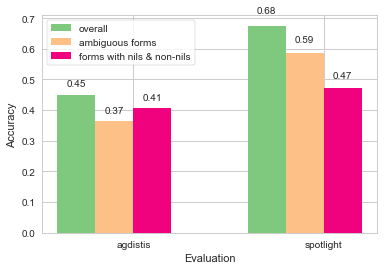

In [60]:
plot_utils.plot_scores(scores, title='Scores of systems')
#plot_scores(scores, title='Scores of systems')

### 3) Correlation between FORM frequency and accuracy

# Note: All stats from here on are on both datasets jointly

<span style="background-color:lightgreen">Section 6.2. of the paper</span>

In [61]:
from scipy.stats import pearsonr, spearmanr

In [62]:
acc_by_form = {'agdistis': defaultdict(float), 'spotlight': defaultdict(float)}
for system in systems:
    acc_by_form[system], forms_by_count = plot_utils.compute_accuracy_by_form(
        system_articles[system], skip_nils)

In [63]:
import math

def counts_to_log_counts(forms_by_count):
    forms_by_log_count={}
    for count, forms in forms_by_count.items():
        try:
            log_count=round(math.log(count), 2)
        except:
            print(count)
        forms_by_log_count[log_count] = forms
    return forms_by_log_count

forms_by_log_count=counts_to_log_counts(forms_by_count)

In [64]:
def lmplot(dist1, dist2):
    data={
        'form frequency': dist1,
        'accuracy': dist2
    }
    df=pd.DataFrame(data)
    ax = sns.lmplot(data=df, x='form frequency', y='accuracy', lowess=True)


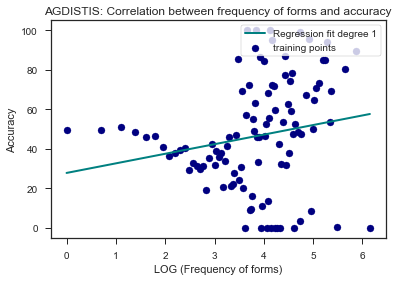

The Spearman correlation between X and Y is: 0.298348750014 . Significance:  0.00220608406723


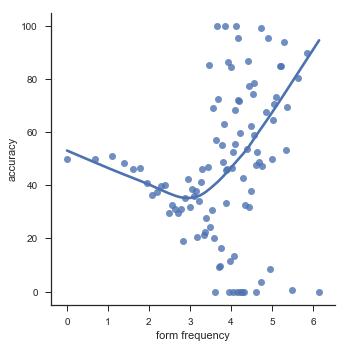

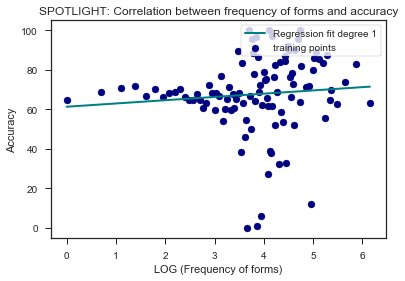

The Spearman correlation between X and Y is: 0.214429275913 . Significance:  0.029628109645


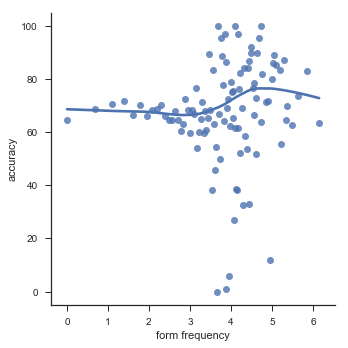

In [65]:
from collections import OrderedDict
import numpy as np
from scipy.stats import kendalltau
import pandas as pd
sns.set(style="ticks")

acc_by_freq={'agdistis': OrderedDict(), 'spotlight': OrderedDict()}

for system in systems:
        
    for count in sorted(forms_by_log_count.keys()):
        count_forms=forms_by_log_count[count]
        s=0
        for form in count_forms:
            s+=acc_by_form[system][form]
        acc_by_freq[system][count]=s/len(count_forms)
        
        
    dist1=np.array(list(acc_by_freq[system].keys()))
    dist2=np.array(list(acc_by_freq[system].values()))
    plot_utils.scatter_plot(dist1, dist2, 
                            title='%s: Correlation between frequency of forms and accuracy' % system.upper(),
                            x_axis='LOG (Frequency of forms)',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

#    fig = plt.figure()
#    sns.jointplot(dist1, dist2, kind="hex", stat_func=kendalltau, color="#4CB391")
#    fig.savefig('img/%s-ff-acc.png' % system)
    lmplot(dist1,dist2)
    
    
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 4) Entropy

In [28]:
from scipy.stats import entropy
form_entropies={}
for form in ambiguous_forms:
    counts=plot_utils.get_form_counts(spot_articles, form)
    counts=list(counts)
    form_entropies[form]=entropy(counts,base=len(counts))

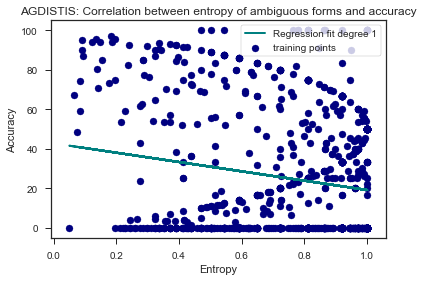

The Spearman correlation between X and Y is: -0.168485849408 . Significance:  2.39419774312e-08


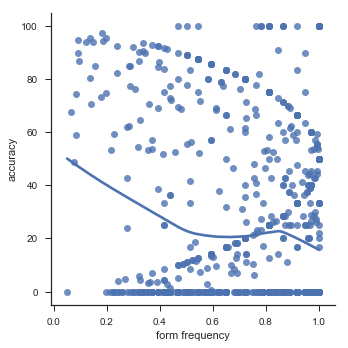

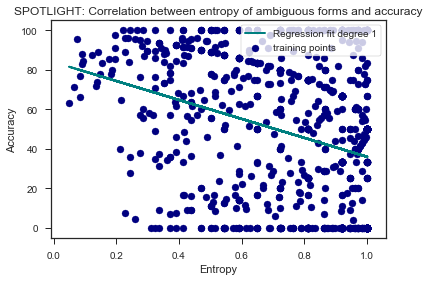

The Spearman correlation between X and Y is: -0.334800309898 . Significance:  8.396394726e-30


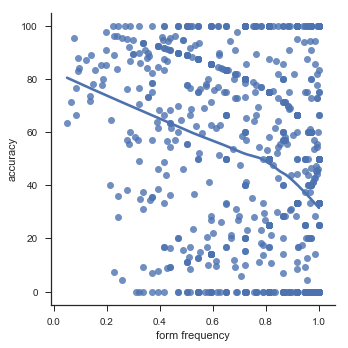

In [29]:
for system in systems:
    dist1=[]
    dist2=[]
    for f in ambiguous_forms:
        dist1.append(form_entropies[f])
        dist2.append(acc_by_form[system][f])

    dist1=np.array(dist1)
    dist2=np.array(dist2)
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between entropy of ambiguous forms and accuracy' % system.upper(),
                            x_axis='Entropy',
                            y_axis='Accuracy',
                            save=True
                            )

    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
    
    #fig = plt.figure()
    #sns.jointplot(dist1, dist2, kind="hex", stat_func=kendalltau, color="#4CB391")
    #
    #fig.savefig('img/%s-ff-acc.png' % system)
    
    lmplot(dist1, dist2)

### 5) Correlation between instance frequency and accuracy

<span style="background-color:lightgreen">Section 6.3. of the paper</span>

In [30]:
acc_by_uri = {'agdistis': defaultdict(float), 'spotlight': defaultdict(float)}
for system in systems:
    acc_by_uri[system], uris_by_count = plot_utils.compute_accuracy_by_uri(
        system_articles[system], skip_nils)

In [31]:
uris_by_log_count=counts_to_log_counts(uris_by_count)

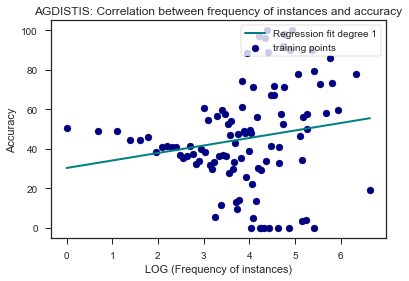

The Spearman correlation between X and Y is: 0.234919997433 . Significance:  0.0163743186628


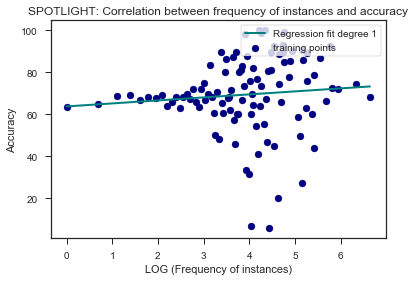

The Spearman correlation between X and Y is: 0.196581128191 . Significance:  0.0454923583454


In [32]:
acc_by_freq_uris={'agdistis': OrderedDict(), 'spotlight': OrderedDict()}

for system in systems:
        
    for count in sorted(uris_by_log_count.keys()):
        count_uris=uris_by_log_count[count]
        s=0
        for uri in count_uris:
            s+=acc_by_uri[system][uri]
        acc_by_freq_uris[system][count]=s/len(count_uris)
        
        
    dist1=np.array(list(acc_by_freq_uris[system].keys()))
    dist2=np.array(list(acc_by_freq_uris[system].values()))
    
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between frequency of instances and accuracy' % system.upper(),
                            x_axis='LOG (Frequency of instances)',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 6) Correlation between instance PageRank and accuracy

In [33]:
skip_zeros=True

In [34]:
uris_by_pr = defaultdict(set)
uri_pr={}
for article in spot_articles:
    for entity in article.entity_mentions:
        if entity.sys_link and (not skip_nils or entity.gold_link!='--NME--'):
            pagerank=int(entity.gold_pr)
            if skip_zeros and pagerank==0: continue
            uris_by_pr[pagerank].add(entity.gold_link)
            uri_pr[entity.gold_link]=entity.gold_pr

In [35]:
uris_by_log_pr=counts_to_log_counts(uris_by_pr)

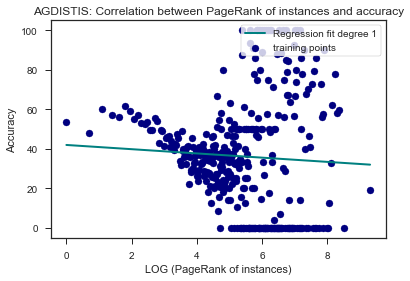

The Spearman correlation between X and Y is: -0.0912649992346 . Significance:  0.0824825164868


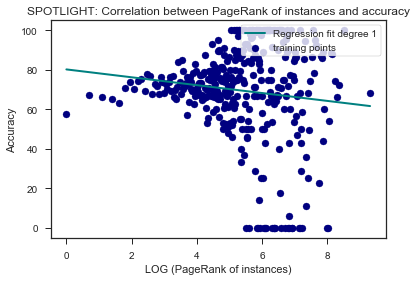

The Spearman correlation between X and Y is: 0.0122513186105 . Significance:  0.816054445893


In [36]:
acc_by_pr_uris={'agdistis': OrderedDict(), 'spotlight': OrderedDict()}

for system in systems:
        
    for pr in sorted(uris_by_log_pr.keys()):


        count_uris=uris_by_log_pr[pr]
        s=0
        for uri in count_uris:
            s+=acc_by_uri[system][uri]
        acc_by_pr_uris[system][pr]=s/len(count_uris)
        
        
    dist1=np.array(list(acc_by_pr_uris[system].keys()))
    dist2=np.array(list(acc_by_pr_uris[system].values()))
    
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between PageRank of instances and accuracy' % system.upper(),
                            x_axis='LOG (PageRank of instances)',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 7) Correlation between instance ranks (of a form) and accuracy

<span style="background-color:lightgreen">Section 6.4. of the paper</span>


**7.1. Collect interpretations for a form**


In [37]:
interpretations=defaultdict(set)
for article in spot_articles:
    for mention in article.entity_mentions:
        form=mention.mention
        meaning=mention.gold_link
        if not skip_nils or meaning!='--NME--':
            interpretations[form].add(meaning)

In [38]:
interpretations['Marseille']

{'Marseille', 'Olympique_de_Marseille'}

**7.2. Aggregate per rank**

In [39]:
len(ambiguity)

19924

defaultdict(<class 'int'>, {1: 11853, 2: 2606, 3: 475, 4: 119, 5: 36, 6: 14, 7: 4, 8: 2, 9: 2, 10: 2, 11: 1, 12: 1})
defaultdict(<class 'float'>, {1: 0.4166877583734076, 2: 0.21527244819646968, 3: 0.14105263157894737, 4: 0.04201680672268908, 5: 0.08333333333333333, 6: 0.14285714285714285, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0})


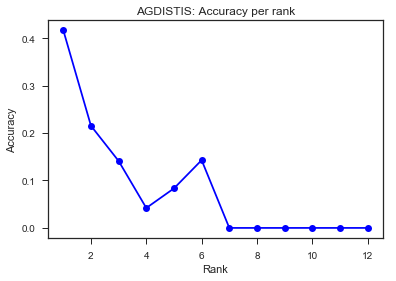

The Spearman correlation between X and Y is: -0.884562387349 . Significance:  0.000132600665866
defaultdict(<class 'int'>, {1: 11853, 2: 2606, 3: 475, 4: 119, 5: 36, 6: 14, 7: 4, 8: 2, 9: 2, 10: 2, 11: 1, 12: 1})
defaultdict(<class 'float'>, {1: 0.6495402007930482, 2: 0.4205679201841903, 3: 0.3452631578947368, 4: 0.33613445378151263, 5: 0.19444444444444445, 6: 0.5, 7: 0.0, 8: 1.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0})


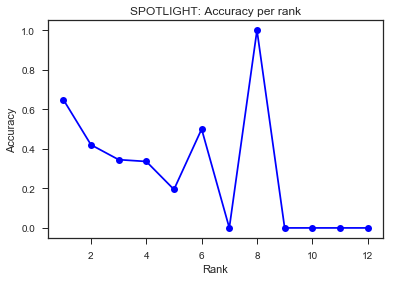

The Spearman correlation between X and Y is: -0.674355818945 . Significance:  0.016163123632


In [40]:
for system in systems:
    correct_per_form=defaultdict(dict)
    total_per_form=defaultdict(dict)
    for article in system_articles[system]:
        for mention in article.entity_mentions:
            form=mention.mention
            meaning=mention.gold_link
            if skip_nils and meaning=='--NME--':
                continue
            if form not in ambiguous_forms:
                continue
            if meaning not in total_per_form[form]:
                total_per_form[form][meaning]=0
                correct_per_form[form][meaning]=0
            total_per_form[form][meaning]+=1
            if meaning==mention.sys_link:
                correct_per_form[form][meaning]+=1
    correct_per_rank, total_per_rank = plot_utils.prepare_ranks(correct_per_form, total_per_form)
#    print(correct_per_rank)
    print(total_per_rank)
    plot_utils.plot_ranks(correct_per_rank, total_per_rank, 
                          title='%s: Accuracy per rank' % system.upper(), save=True)
    


### 8) Ranks of the top-N most frequent forms

<span style="background-color:lightgreen">Section 6.5. of the paper</span>


U.S.
Italy
Australia
Spain
France
Germany
Britain
German
England
Russia
defaultdict(<class 'float'>, {1: 0.6427947598253275, 2: 0.01775147928994083, 3: 0.0, 4: 0.0, 5: 0.0, 6: 1.0})


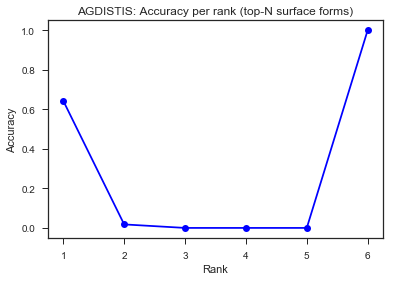

The Spearman correlation between X and Y is: -0.0303588370359 . Significance:  0.954475734694
Germany
Italy
Russia
Spain
U.S.
Britain
France
German
Australia
England
defaultdict(<class 'float'>, {1: 0.7087336244541484, 2: 0.8461538461538461, 3: 0.7878787878787878, 4: 0.631578947368421, 5: 0.0, 6: 1.0})


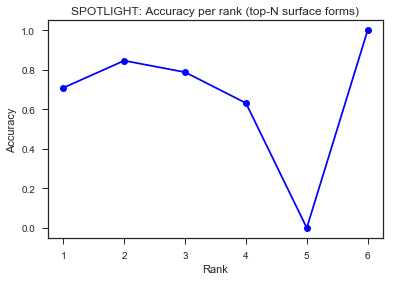

The Spearman correlation between X and Y is: 0.0285714285714 . Significance:  0.95715451895


In [41]:
# Top 10 have form frequency of >135
min_frequency=170
for system in systems:
    correct_per_form=defaultdict(dict)
    total_per_form=defaultdict(dict)
    for article in system_articles[system]:
        for mention in article.entity_mentions:
            form=mention.mention
            meaning=mention.gold_link
            if skip_nils and meaning=='--NME--':
                continue
            if form not in ambiguous_forms:
                continue
            if meaning not in total_per_form[form]:
                total_per_form[form][meaning]=0
                correct_per_form[form][meaning]=0
            total_per_form[form][meaning]+=1
            if meaning==mention.sys_link:
                correct_per_form[form][meaning]+=1
    correct_per_rank, total_per_rank = plot_utils.prepare_ranks(correct_per_form, 
                                                                total_per_form, 
                                                                min_frequency=min_frequency)
#    print(correct_per_rank)
#    print(total_per_rank)
    plot_utils.plot_ranks(correct_per_rank, total_per_rank, 
                          title='%s: Accuracy per rank (top-N surface forms)' % system.upper(), save=True)
    


#### The reason for the peak in form 3 is NEW YORK, where the state is third most common in the corpus

In [42]:
form='England'
print(total_per_form[form])
print(correct_per_form[form])

{'England': 142, 'England_cricket_team': 69, 'United_Kingdom': 3, 'England_national_football_team': 16, 'England_national_rugby_union_team': 10, 'Kingdom_of_England': 1}
{'England': 56, 'England_cricket_team': 69, 'United_Kingdom': 0, 'England_national_football_team': 15, 'England_national_rugby_union_team': 10, 'Kingdom_of_England': 1}


In [43]:
form='Germany'
print(total_per_form[form])
print(correct_per_form[form])

{'Germany': 342, 'Germany_Davis_Cup_team': 1, "Germany_men's_national_ice_hockey_team": 1, 'Germany_Fed_Cup_team': 1, 'Germany_national_football_team': 6}
{'Germany': 285, 'Germany_Davis_Cup_team': 0, "Germany_men's_national_ice_hockey_team": 0, 'Germany_Fed_Cup_team': 0, 'Germany_national_football_team': 6}


#### What is going on with China?

In [44]:
for a in spot_articles:
    for m in a.entity_mentions:
        if m.mention=='China':
            print(m.gold_link, m.sys_link)

China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
Qing_dynasty China
China China
China China
China China
China Economy_of_China
China Economy_of_China
China Economy_of_China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
Taiwan China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China China
China Economy_of_China
China China
China China
China China
China China


### 7) PageRank analysis

<span style="background-color:lightgreen">Section 6.6. of the paper</span>

In [45]:
uri_pr

{'Landgraaf': 1.7732,
 'Netherlands': 1571.5309,
 'Ronde_van_Nederland': 1.4545,
 'Roermond': 9.3432,
 'Olaf_Ludwig': 1.3974,
 'Germany': 3766.7304,
 'Italy': 2466.5223,
 'Team_Polti': 1.3533,
 'TVM_(cycling_team)': 1.8813,
 'Team_LottoNL–Jumbo': 4.7894,
 'Denmark': 893.3314,
 'Viatcheslav_Ekimov': 2.379,
 'Russia': 2613.6298,
 'Spain': 1981.6875,
 'Sweden': 1440.7168,
 'Belgium': 1012.9973,
 'Cycle_Collstrop': 3.8215,
 'Rolf_Sørensen': 1.4938,
 'Lance_Armstrong': 16.3667,
 'United_States': 11066.2733,
 '7-Eleven_(cycling_team)': 2.6461,
 'Erik_Dekker': 1.2686,
 'January_18': 2.0301,
 '1854': 1.322,
 'Telephone': 141.1885,
 'Shipbuilding': 76.8329,
 'Thomas_A._Watson': 1.7641,
 'Telephone_call': 18.0793,
 'Alexander_Graham_Bell': 46.1289,
 'Bell_Telephone_Company': 9.7628,
 'Government': 345.7854,
 'Salem,_Massachusetts': 34.2525,
 'School': 129.28,
 'Bookkeeping': 20.8094,
 'Carpentry': 50.2279,
 'Boston': 690.2061,
 'Machine': 52.7585,
 'Teacher': 127.3844,
 'Deaf-mute': 7.4107,
 'Ac

In [46]:
acc_by_form

{'agdistis': defaultdict(int,
             {'Chelsea': 25.0,
              'FA Cup': 0.0,
              'SYDNEY': 100.0,
              'Sydney': 42.857142857142854,
              'U.S.': 0.0,
              'CHESAPEAKE': 0.0,
              'GMT': 100.0,
              'Camelot': 0.0,
              'Virginia': 100.0,
              'January 14': 0.0,
              '1902': 0.0,
              'Polish-American': 0.0,
              'mathematician': 0.0,
              'logician': 0.0,
              'Alfred Tarski': 100.0,
              'model theory': 0.0,
              'metamathematics': 0.0,
              'algebraic logic': 100.0,
              'abstract algebra': 0.0,
              'topology': 0.0,
              'geometry': 0.0,
              'mathematical logic': 0.0,
              'set theory': 0.0,
              'analytic philosophy': 0.0,
              'Semantic Web': 0.0,
              'lecture series': 100.0,
              'semantics': 0.0,
              'representation': 0.0,
        

defaultdict(<class 'int'>, {1: 4926, 2: 546, 3: 52, 4: 22, 5: 2, 6: 0, 7: 4, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
defaultdict(<class 'int'>, {1: 9823, 2: 3824, 3: 822, 4: 171, 5: 117, 6: 31, 7: 9, 8: 1, 9: 3, 10: 5, 11: 5, 12: 1})
defaultdict(<class 'float'>, {1: 0.5014761274559707, 2: 0.14278242677824268, 3: 0.06326034063260341, 4: 0.1286549707602339, 5: 0.017094017094017096, 6: 0.0, 7: 0.4444444444444444, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0})


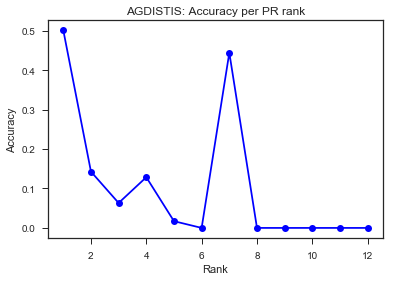

The Spearman correlation between X and Y is: -0.798718780138 . Significance:  0.0018354045665
defaultdict(<class 'int'>, {1: 6720, 2: 1898, 3: 219, 4: 57, 5: 88, 6: 13, 7: 2, 8: 0, 9: 0, 10: 0, 11: 5, 12: 0})
defaultdict(<class 'int'>, {1: 9823, 2: 3824, 3: 822, 4: 171, 5: 117, 6: 31, 7: 9, 8: 1, 9: 3, 10: 5, 11: 5, 12: 1})
defaultdict(<class 'float'>, {1: 0.6841087244222742, 2: 0.4963389121338912, 3: 0.2664233576642336, 4: 0.3333333333333333, 5: 0.7521367521367521, 6: 0.41935483870967744, 7: 0.2222222222222222, 8: 0.0, 9: 0.0, 10: 0.0, 11: 1.0, 12: 0.0})


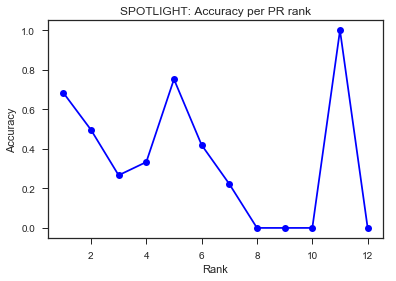

The Spearman correlation between X and Y is: -0.466265989365 . Significance:  0.126534787903


In [47]:
#acc_per_form_meaning={'agdistis': {}, 'spotlight': {}}
for system in systems:
    correct_per_rank_pr=defaultdict(int)
    total_per_rank_pr=defaultdict(int)

    correct_per_form=defaultdict(dict)
    total_per_form=defaultdict(dict)
    for article in system_articles[system]:
        for mention in article.entity_mentions:
            form=mention.mention
            meaning=mention.gold_link
            if skip_nils and meaning=='--NME--':
                continue
            if form not in ambiguous_forms:
                continue
            if meaning not in total_per_form[form]:
                total_per_form[form][meaning]=0
                correct_per_form[form][meaning]=0
            total_per_form[form][meaning]+=1
            if meaning==mention.sys_link:
                correct_per_form[form][meaning]+=1
    for form, meanings in total_per_form.items():
        #for uri, total in meanings.items():
            #acc_per_form_meaning[system][form][uri]=correct_per_form[form][uri]/total
        form_pageranks=[]
        for uri in meanings.keys():
            if uri in uri_pr:
                form_pageranks.append(tuple((uri_pr[uri], uri)))
        form_pageranks = sorted(form_pageranks, reverse=True)
        for rank in range(1,len(form_pageranks)+1):
            correct_per_rank_pr[rank]+=correct_per_form[form][form_pageranks[rank-1][1]]
            total_per_rank_pr[rank]+=total_per_form[form][form_pageranks[rank-1][1]]

    print(correct_per_rank_pr)
    print(total_per_rank_pr)
    plot_utils.plot_ranks(correct_per_rank_pr, total_per_rank_pr, 
                          title='%s: Accuracy per PR rank' % system.upper(), save=True)


### 8) Notes

* very basic baseline - throw away dbpedia, randomly assign from the training data - build this baseline
* always try the most frequent one
* popular, transparent, and the best one - distinguish between open source systems
* look at coreference too (noun phrases and pronouns)
* annotation or not of coreferential expressions (we can also just use them in a solution)? 

**5.3. Aggregate per rank**



#### Summary of the todos:
* Another system or 2 (spotlight) - PIEK: take popular, transparent, and the best one
* More datasets
* NIL entities
* Baseline
* Coreference